# import 

In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optimizers
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms
import matplotlib
# matplotlib.use('Agg')
import matplotlib.pyplot as plt

# VAE

In [2]:
class VAE(nn.Module):
    def __init__(self, device='cpu'):
        super().__init__()
        self.device = device
        self.encoder = Encoder(device=device)
        self.decoder = Decoder(device=device)

    def forward(self, x):
        mean, var = self.encoder(x)
        z = self.reparameterize(mean, var)
        y = self.decoder(z)

        return y

    def reparameterize(self, mean, var):
        eps = torch.randn(mean.size()).to(self.device)
        z = mean + torch.sqrt(var) * eps
        self.z = z
        return z

    def lower_bound(self, x):
        mean, var = self.encoder(x)
        kl = - 1/2 * torch.mean(torch.sum(1
                                          + torch.log(var)
                                          - mean**2
                                          - var, dim=1))
        z = self.reparameterize(mean, var)
        y = self.decoder(z)

        reconst = torch.mean(torch.sum(x * torch.log(y)
                                       + (1 - x) * torch.log(1 - y),
                                       dim=1))

        L = reconst - kl

        return L


class Encoder(nn.Module):
    def __init__(self, device='cpu'):
        super().__init__()
        self.device = device
        self.l1 = nn.Linear(n_in, n_h)
        self.l2 = nn.Linear(n_h, n_h)
        self.l_mean = nn.Linear(n_h, n_latent)
        self.l_var = nn.Linear(n_h, n_latent)

    def forward(self, x):
        h = self.l1(x)
        h = torch.relu(h)
        h = self.l2(h)
        h = torch.relu(h)

        mean = self.l_mean(h)
        var = F.softplus(self.l_var(h))

        return mean, var


class Decoder(nn.Module):
    def __init__(self, device='cpu'):
        super().__init__()
        self.device = device
        self.l1 = nn.Linear(n_latent, n_h)
        self.l2 = nn.Linear(n_h, n_h)
        self.out = nn.Linear(n_h, n_in)

    def forward(self, x):
        h = self.l1(x)
        h = torch.relu(h)
        h = self.l2(h)
        h = torch.relu(h)
        h = self.out(h)
        y = torch.sigmoid(h)

        return y

# Load data

In [3]:
np.random.seed(1234)
torch.manual_seed(1234)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Fasion MNIST

In [4]:
transform = transforms.Compose([transforms.ToTensor(),
                                lambda x: x.view(-1)])

root = './data/fashion_mnist'
mnist_train = \
    torchvision.datasets.FashionMNIST(root=root,
                                      download=True,
                                      train=True,
                                      transform=transform)
train_dataloader = DataLoader(mnist_train,
                              batch_size=100,
                              shuffle=True)

## MNIST

In [7]:
root = './data/mnist'
mnist_train = \
    torchvision.datasets.MNIST(root=root,
                                      download=True,
                                      train=True,
                                      transform=transform)
train_dataloader = DataLoader(mnist_train,
                              batch_size=100,
                              shuffle=True)

# Build model

In [8]:
n_in=784
n_h=200
n_latent=2

In [9]:
model = VAE(device=device).to(device)

# Train model

In [10]:
criterion = model.lower_bound
optimizer = optimizers.Adam(model.parameters())

def compute_loss(x):
    return -1 * criterion(x)

def train_step(x):
    model.train()
    loss = compute_loss(x)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return loss

epochs = 10

for epoch in range(epochs):
    train_loss = 0.

    for (x, _) in train_dataloader:
        x = x.to(device)
        loss = train_step(x)

        train_loss += loss.item()

    train_loss /= len(train_dataloader)

    print('Epoch: {}, Cost: {:.3f}'.format(
        epoch+1,
        train_loss
    ))

Epoch: 1, Cost: 185.791
Epoch: 2, Cost: 162.368
Epoch: 3, Cost: 156.567
Epoch: 4, Cost: 152.877
Epoch: 5, Cost: 150.524
Epoch: 6, Cost: 148.699
Epoch: 7, Cost: 147.464
Epoch: 8, Cost: 146.326
Epoch: 9, Cost: 145.431
Epoch: 10, Cost: 144.579


# Test model

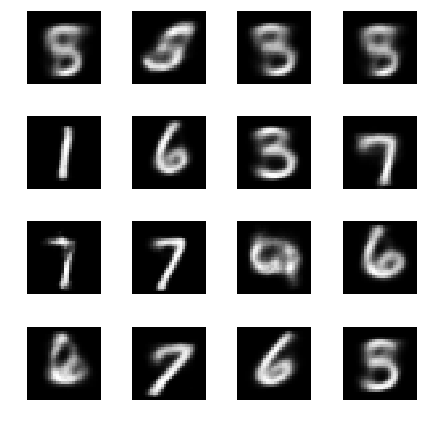

In [11]:
def gen_noise(batch_size):
    return torch.empty(batch_size, n_latent).normal_().to(device)

def generate(batch_size=16):
    model.eval()
    z = gen_noise(batch_size)
    gen = model.decoder(z)
    gen = gen.view(-1, 28, 28)

    return gen

images = generate(batch_size=16)
images = images.squeeze().detach().cpu().numpy()
plt.figure(figsize=(6, 6))
for i, image in enumerate(images):
    plt.subplot(4, 4, i+1)
    plt.imshow(image, cmap='binary_r')
    plt.axis('off')
plt.tight_layout()
plt.show()

# Z

In [12]:
from itertools import chain

In [13]:
x = torch.from_numpy(images[0])

zs = np.empty((0,2), int)
nums = np.empty((0), int)
for x, num in train_dataloader:
    mean, var = model.encoder(x)
    kl = - 1/2 * torch.mean(torch.sum(1
                                      + torch.log(var)
                                      - mean**2
                                      - var, dim=1))
    z = model.reparameterize(mean, var)
    z = z.detach().numpy()
    zs = np.vstack([zs, z])
    
    num = num.detach().numpy()
    nums = np.hstack([nums, num])
   
    

# zs = list(chain.from_iterable(zs))
# nums = list(chain.from_iterable(nums))

# plot Z in 2 dimension

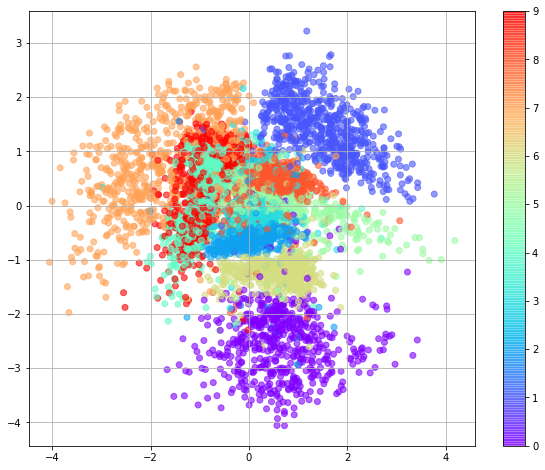

In [14]:
sample_number = 6000

plt.figure(figsize=(10, 8)) 
plt.scatter(zs[0:sample_number][:, 0], zs[0:sample_number][:, 1], c=nums[0:sample_number], cmap="rainbow", alpha=0.6)

plt.colorbar()
plt.grid()

# get mean Z each num

In [15]:
z_mean = {}
for i in range(10):
    z_array = np.empty((0, 2), int)
    for z, num in zip(zs, nums):
        if num == i:
            z_array = np.vstack([z_array, z])
    
    z_array = np.mean(z_array, axis=0)
    z_mean[i] = z_array

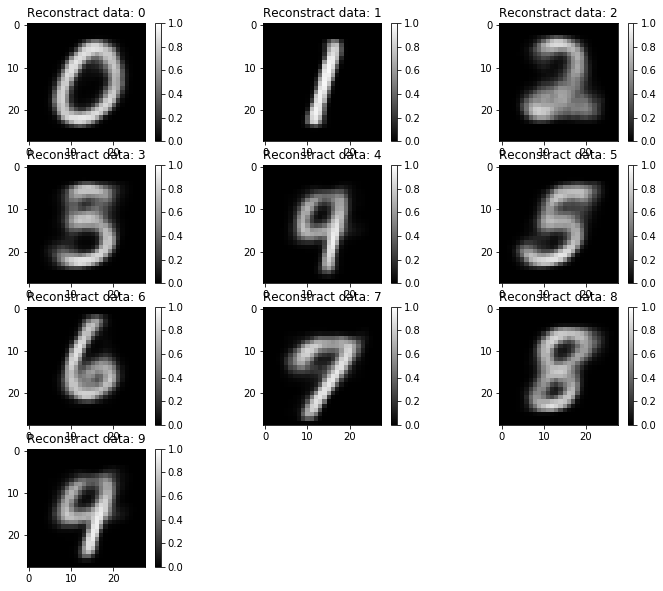

In [17]:
plt.figure(figsize=(12,10))
for i in z_mean.keys():
    z = z_mean[i]

    model.eval()
    z = torch.from_numpy(z.astype(np.float32))
    gen = model.decoder(z)
    gen = gen.view(-1, 28, 28)
    gen = gen.squeeze().detach().numpy()
    
    plt.subplot(4,3,i+1)
    plt.imshow(gen, vmin=0, vmax=1, cmap="gray")
    plt.title("Reconstract data: {}".format(i))
    plt.colorbar()

In [103]:
x = images[0]
#x = x.to(device)
mean, var = model.forward(x)
model.reparameterize(mean, var)

AttributeError: 'numpy.ndarray' object has no attribute 'dim'

# Z

In [54]:
import PIL
import PIL.Image as Image
import matplotlib.pyplot as plt

In [55]:
z = model.z
z = z.detach().numpy()

In [60]:
z[0]

array([-0.5908052 , -0.5851298 ,  1.1160551 ,  0.2873503 ,  0.23720768,
       -0.33868504, -1.5282612 , -0.3443127 , -0.45080593,  0.35831648],
      dtype=float32)

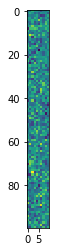

In [67]:
plt.imshow(z)
plt.show()

<module 'PIL' from '/Users/yuya/anaconda3/lib/python3.6/site-packages/PIL/__init__.py'>

In [44]:
z.shape

(100, 10)

In [46]:
z

array([[-5.90805173e-01, -5.85129797e-01,  1.11605513e+00,
         2.87350297e-01,  2.37207681e-01, -3.38685036e-01,
        -1.52826118e+00, -3.44312698e-01, -4.50805932e-01,
         3.58316481e-01],
       [-3.76085490e-01,  9.58911300e-01,  2.34421209e-01,
        -1.08911455e+00, -3.74232531e-01, -1.28069675e+00,
         2.86521226e-01, -9.71340761e-02,  2.00621784e-01,
        -1.22736633e+00],
       [-9.38026011e-01, -1.74349129e-01, -4.84111577e-01,
        -5.79062440e-02,  8.10897708e-01, -9.03057396e-01,
        -2.20962167e+00, -1.93361008e+00, -1.63458273e-01,
         9.40606892e-01],
       [ 4.83818620e-01,  6.97658420e-01, -6.80240333e-01,
         1.07931709e+00,  5.84217727e-01, -1.52543795e+00,
         8.04073393e-01, -6.53138697e-01,  6.33205414e-01,
        -3.69909197e-01],
       [ 3.60330790e-02,  2.38086909e-01,  1.00990140e+00,
        -3.61456573e-02,  5.33064902e-01,  2.31924772e+00,
         1.82086959e-01, -1.15442109e+00, -3.10374677e-01,
         1.

In [45]:
Image.fromarray(z)

OSError: cannot write mode F as PNG

<PIL.Image.Image image mode=F size=10x100 at 0x113937D68>